In [1]:
#Importing Necessary Packages
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2.4.1


In [2]:
!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [3]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

In [4]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [5]:
#Downloading the SUSY dataset from UCI
data = tf.keras.utils.get_file('SUSY.csv.gz', 'http://mlphysics.ics.uci.edu/data/susy/SUSY.csv.gz')

In [6]:
#Taking Maximum Features=18
FEATURES = 18

In [7]:
#The tf.data.experimental.CsvDataset class can be used to read csv records directly from a gzip file with no intermediate decompression step.

susydata = tf.data.experimental.CsvDataset(data,[float(),]*(FEATURES+1), compression_type="GZIP")

In [8]:
#That csv reader class returns a list of scalars for each record. The following function repacks that list of scalars into a (feature_vector, label) pair.

def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

In [9]:
#So instead of repacking each row individually make a new Dataset that takes batches of 10000-examples,
#It applies the pack_row function to each batch, and then splits the batches back up into individual records:

packed_susy = susydata.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.97286147  0.65385455  1.1762246   1.1571565  -1.7398732  -0.87430906
  0.567765   -0.17500004  0.81006074 -0.25255212  1.921887    0.8896374
  0.41077185  1.1456208   1.9326321   0.9944641   1.3678155   0.0407145 ], shape=(18,), dtype=float32)


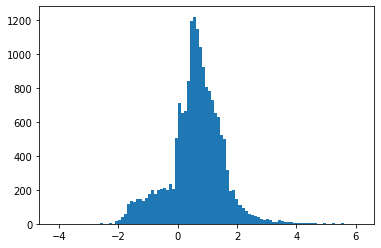

In [10]:
#Looking at the Packed SUSY dataset
for features,label in packed_susy.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

In [11]:
#To keep this tutorial relatively short use just the first 1000 samples for validation, and the next 10 000 for training:

N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE


In [12]:
validate_ds = packed_susy.take(N_VALIDATION).cache()
train_ds = packed_susy.skip(N_VALIDATION).take(N_TRAIN).cache()



In [13]:
train_ds

<CacheDataset shapes: ((18,), ()), types: (tf.float32, tf.float32)>

In [14]:
#These datasets return individual examples. Use the .batch method to create batches of an appropriate size for training. 
#Before batching also remember to .shuffle and .repeat the training set.

validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)


In [15]:
#Demonstrate Overfitting
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

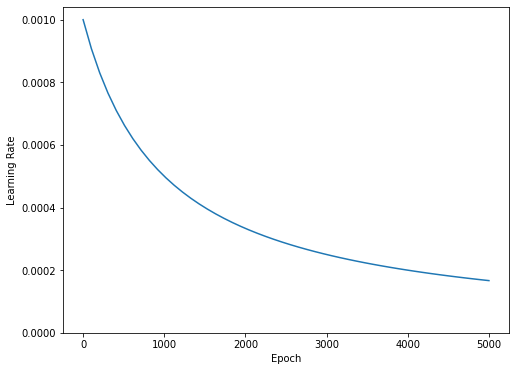

In [16]:
#Plotting the Learning Rate and Epoch
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [17]:
#Use callbacks.TensorBoard to generate TensorBoard logs for the training.

def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

In [18]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.losses.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=0)
  return history

In [19]:
#Small Model using less layers to prevent overfitting on training data
small_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

In [20]:
size_histories = {}
size_histories['Tiny'] = compile_and_fit(small_model, 'sizes/Tiny')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                304       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5681,  binary_crossentropy:0.7905,  loss:0.7905,  val_accuracy:0.5730,  val_binary_crossentropy:0.7237,  val_loss:0.7237,  
....................................................................................................
Epoch: 100, accuracy:0.7877,  binary_crossentropy:0.4438,  loss:0.4438,  val_accuracy:0.7880,  val_binary_crossentropy:0.4347,  val_loss:0.4347,  
....................................................................................................
Epoch: 200, accuracy:0.78

In [21]:
#As an exercise, you can create an even larger model, and see how quickly it begins overfitting. 
#Next, let's add to this benchmark a network that has much more capacity, far more than the problem would warrant:

model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

In [22]:
#again train the model using the same data:
size_histories['large'] = compile_and_fit(model, "sizes/large")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 512)               9728      
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 513       
Total params: 798,209
Trainable params: 798,209
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.6712,  binary_crossentropy:0.6649,  loss:0.6649,  val_accuracy:0.7800,  val_binary_crossentr

Text(0.5, 0, 'Epochs [Log Scale]')

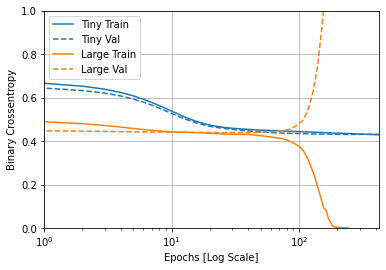

In [27]:
#Plotting the Training and Validation Loss using Log Scale
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([1, max(plt.xlim())])
plt.ylim([0, 1])
plt.xlabel("Epochs [Log Scale]")